# Solve surface volatiles according to outgassing+chemistry

In [1]:
import sys
sys.path.append("..")
from proteus.utils.surface_gases import *

from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Set up initial options dict

In [2]:
OPTIONS = {}

OPTIONS['Phi_global'] = 1.0
OPTIONS['T_magma'] = 2500.0
OPTIONS['radius'] = 6.371e6 #* 1.875
OPTIONS['mass']   = 5.972e24 #* 7.99
OPTIONS['gravity'] = 6.67e-11 * OPTIONS['mass'] / (OPTIONS['radius']**2)
OPTIONS['hydrogen_earth_oceans'] = 8.0
OPTIONS['CH_ratio'] = 1.0
OPTIONS['fO2_shift_IW'] = 0.0
OPTIONS['nitrogen_ppmw'] = 4.0
OPTIONS['sulfur_ppmw'] = 300.0
OPTIONS['planet_coresize'] = 0.5

solvevol_vols = ['H2O', 'CO2', 'N2', 'H2', 'CO', 'CH4', 'S2', 'SO2']
for v in solvevol_vols:
    OPTIONS[v+"_included"] = 0
    OPTIONS[v+"_initial_bar"] = 0.0

OPTIONS["H2O_included"] = 1
OPTIONS["CO2_included"] = 1
OPTIONS["N2_included"]  = 1
OPTIONS["S2_included"]  = 1

OPTIONS["H2_included"]  = 1
OPTIONS["CO_included"]  = 1
OPTIONS["CH4_included"] = 1
OPTIONS["SO2_included"] = 1

print("Gravity = %.3f m.s-2" % OPTIONS["gravity"])

Gravity = 9.814 m.s-2


### Calculate total amount of each element in the system

In [3]:
OPTIONS["M_mantle"] = CalculateMantleMass(OPTIONS["radius"], OPTIONS["mass"], OPTIONS["planet_coresize"])
BACKUP_options = deepcopy(OPTIONS)

In [4]:
solvevol_target = get_target_from_params(OPTIONS)
# solvevol_target = get_target_from_pressures(OPTIONS)

print("Targets:")
print(solvevol_target)

Targets:
{'H': 1.24e+21, 'C': 1.24e+21, 'N': 1.8054299266814261e+19, 'S': 1.3540724450110695e+21}


### Parameter grid

/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:226: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:121: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:226: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:253: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:423: RuntimeWarning: overflow encountered in scalar multiply
  mass_int_d['N2'] = prefactor*ppmw_N2
/dataserve

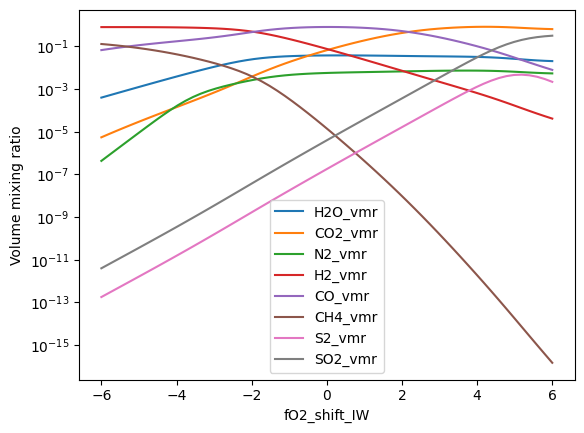

In [7]:
plt.close("all")

# parameters
x_arr = np.linspace(-6, 6, 60)
x_key = "fO2_shift_IW"
y_keys = [v+"_vmr" for v in solvevol_vols]
y_keys.extend([v+"_bar" for v in solvevol_vols])

# run model
y_out = {}
for y in y_keys:
    y_out[y] = []
for x in x_arr:
    OPTIONS = deepcopy(BACKUP_options)
    OPTIONS[x_key] = x
    solvevol_target = get_target_from_params(OPTIONS)
    p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)
    for y in y_keys:
        y_out[y].append(p_d[y])


# plot data
fig,ax = plt.subplots(1,1)

for y in y_keys:
    if "_vmr" in y:
        ax.plot(x_arr, y_out[y], label=y)
ax.set(xlabel=x_key, ylabel="Volume mixing ratio")
ax.legend()
ax.set_yscale("log")

plt.show()


# write to csv
M = []
header = x_key
M.append(x_arr)
for y in y_keys:
    M.append(y_out[y])
    header += " "+y
M = np.array(M).T
np.savetxt("nogit_solvevol.csv", M, fmt="%.4e", header=header, comments="")